# Environment

## Imports

In [75]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from muon import atac as ac
import torch
import seaborn as sns
import anndata as ad

from pathlib import Path
from typing import Optional, Dict, Any, Tuple
from scipy import sparse
from scipy.stats import spearmanr, pearsonr

from src.peak2vec.models import Peak2Vec

## Load data

In [76]:
adata = sc.read_h5ad("data/pbmc10k.h5ad")
adata.var["Center"] = (adata.var["End"] + adata.var["Start"]) // 2
adata

AnnData object with n_obs × n_vars = 10167 × 260822
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Center'
    layers: 'binary'

### Model checkpoint

In [77]:
checkpoint_path = "output/peak2vec/checkpoints/checkpoint_epoch3600.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
n_peaks = checkpoint["model_state_dict"]["in_embedding.weight"].shape[0]
embedding_dim = checkpoint["model_state_dict"]["in_embedding.weight"].shape[
    1
]
model = Peak2Vec(
    n_peaks=n_peaks,
    embedding_dim=embedding_dim,
    pos_weight=1.0,
    sparse=False,
    tie_weights=False,
)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Helper funcitons

In [78]:
def l2_normalize(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True)
    return x / (n + eps)


def sample_same_chr_pairs(
    chrom: np.ndarray, n_pairs: int, rng: np.random.Generator
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    chrom = chrom.astype(str)
    uniq, inv = np.unique(chrom, return_inverse=True)
    idx_by_chr = [np.where(inv == k)[0] for k in range(len(uniq))]
    sizes = np.array([len(v) for v in idx_by_chr], dtype=np.float64)
    probs = sizes / sizes.sum()

    chr_ids = rng.choice(len(uniq), size=n_pairs, replace=True, p=probs)
    i = np.empty(n_pairs, dtype=np.int64)
    j = np.empty(n_pairs, dtype=np.int64)

    for cid in np.unique(chr_ids):
        m = int(np.sum(chr_ids == cid))
        pool = idx_by_chr[cid]
        picks = rng.choice(pool, size=(m, 2), replace=True)
        ii, jj = picks[:, 0], picks[:, 1]

        # avoid self-pairs
        same = ii == jj
        while np.any(same):
            jj[same] = rng.choice(pool, size=int(np.sum(same)), replace=True)
            same = ii == jj

        mask = chr_ids == cid
        i[mask] = ii
        j[mask] = jj
    return uniq[chr_ids], i, j


def peak_distance_eval(
    peak_emb: np.ndarray,
    chrom: np.ndarray,
    center: np.ndarray,
    *,
    n_pairs: int = 200_000,
    seed: int = 4,
) -> Dict[str, Any]:
    rng = np.random.default_rng(seed)

    peak_emb = l2_normalize(peak_emb.astype(np.float32))
    center = center.astype(np.int64)

    i, j = sample_same_chr_pairs(chrom, n_pairs, rng)
    dist = np.abs(center[i] - center[j]).astype(np.float64)
    sim = np.sum(peak_emb[i] * peak_emb[j], axis=1).astype(np.float64)  # cosine

    # Correlate similarity with -log(1+distance) (monotonic decay expectation)
    x = -np.log1p(dist)
    s_r, s_p = spearmanr(sim, x)
    p_r, p_p = pearsonr(sim, x)

    # Distance bins for interpretability
    bin_edges = np.array([0, 1_000, 10_000, 100_000, 1_000_000, 10_000_000, np.inf])
    bin_names = ["0-1kb", "1-10kb", "10-100kb", "100kb-1Mb", "1-10Mb", ">10Mb"]
    bin_id = np.digitize(dist, bin_edges) - 1

    mean_sim = {}
    frac = {}
    for b, name in enumerate(bin_names):
        m = bin_id == b
        mean_sim[name] = float(np.mean(sim[m])) if np.any(m) else float("nan")
        frac[name] = float(np.mean(m))

    return {
        "n_pairs": int(n_pairs),
        "spearman_r": float(s_r),
        "spearman_p": float(s_p),
        "pearson_r": float(p_r),
        "pearson_p": float(p_p),
        "mean_cosine_by_distance_bin": mean_sim,
        "pair_fraction_by_distance_bin": frac,
    }


def stratified_subsample(
    labels: np.ndarray, max_n: int, rng: np.random.Generator
) -> np.ndarray:
    n = labels.shape[0]
    if n <= max_n:
        return np.arange(n, dtype=np.int64)

    labels = labels.astype(str)
    uniq = np.unique(labels)
    per = max(1, max_n // len(uniq))

    chosen = []
    for u in uniq:
        idx = np.where(labels == u)[0]
        take = min(per, idx.size)
        chosen.append(rng.choice(idx, size=take, replace=False))
    chosen = np.concatenate(chosen)

    if chosen.size < max_n:
        remaining = np.setdiff1d(np.arange(n), chosen, assume_unique=False)
        extra = rng.choice(remaining, size=(max_n - chosen.size), replace=False)
        chosen = np.concatenate([chosen, extra])

    rng.shuffle(chosen)
    return chosen.astype(np.int64)


def knn_metrics_cosine(
    X: np.ndarray,
    labels: np.ndarray,
    *,
    k: int = 15,
    batch_size: int = 512,
) -> Dict[str, Any]:
    X = l2_normalize(X.astype(np.float32))
    labels = labels.astype(str)
    classes, y = np.unique(labels, return_inverse=True)
    n = X.shape[0]
    c = classes.size

    pred = np.empty(n, dtype=np.int64)
    purity = np.empty(n, dtype=np.float32)

    for start in range(0, n, batch_size):
        end = min(n, start + batch_size)
        sims = X[start:end] @ X.T  # cosine
        # exclude self
        rows = np.arange(start, end)
        sims[np.arange(end - start), rows] = -np.inf

        nn = np.argpartition(-sims, kth=k - 1, axis=1)[:, :k]
        nn_y = y[nn]

        counts = np.zeros((end - start, c), dtype=np.int32)
        np.add.at(counts, (np.arange(end - start)[:, None], nn_y), 1)
        pred_batch = counts.argmax(axis=1)

        pred[start:end] = pred_batch
        y_true = y[start:end]
        purity[start:end] = (nn_y == y_true[:, None]).mean(axis=1)

    acc = float(np.mean(pred == y))

    # macro-F1 from confusion matrix
    cm = np.zeros((c, c), dtype=np.int64)
    np.add.at(cm, (y, pred), 1)
    tp = np.diag(cm).astype(np.float64)
    fp = (cm.sum(axis=0) - tp).astype(np.float64)
    fn = (cm.sum(axis=1) - tp).astype(np.float64)

    precision = tp / np.maximum(tp + fp, 1.0)
    recall = tp / np.maximum(tp + fn, 1.0)
    f1 = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
    macro_f1 = float(np.mean(f1))

    return {
        "n_cells": int(n),
        "n_classes": int(c),
        "k": int(k),
        "accuracy": acc,
        "macro_f1": macro_f1,
        "mean_neighbor_purity": float(np.mean(purity)),
    }

# Evaluate

## Peak embeddings

In [79]:
emb_adata = ad.AnnData(
    X=model.get_peak_embeddings(normalize=True, which="avg").numpy()
)

emb_adata.obs = adata.var
emb_adata

AnnData object with n_obs × n_vars = 260822 × 128
    obs: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Center'

In [80]:
sc.pp.neighbors(emb_adata, n_neighbors=15, use_rep="X")
sc.tl.umap(emb_adata)

In [81]:
sc.pp.pca(emb_adata, n_comps=50)

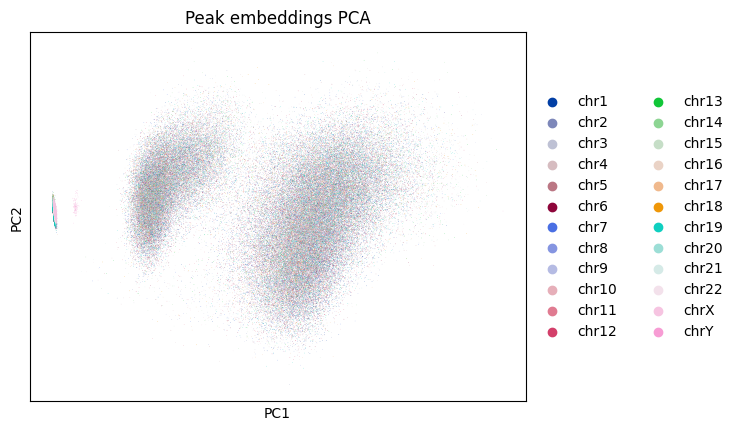

In [82]:
sc.pl.pca(emb_adata, color=["Chromosome"], title="Peak embeddings PCA")

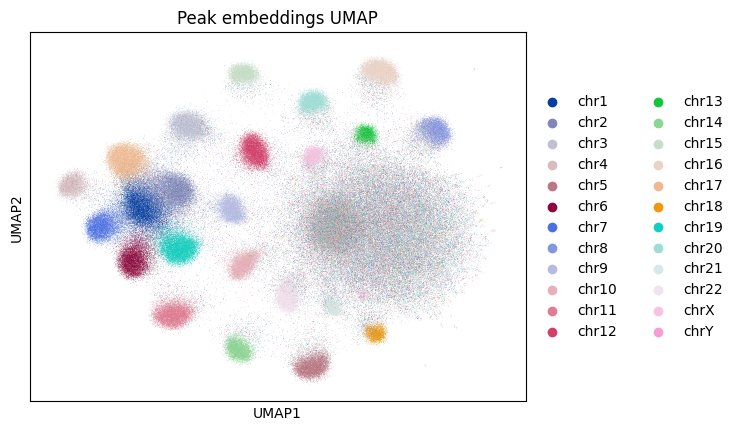

In [83]:
sc.pl.umap(emb_adata, color=["Chromosome"], title="Peak embeddings UMAP")

Check if embeddings capture peak distances chromosome-wise

In [84]:
adata.var.cisTopic_log_nr_acc.iloc[i]

np.float64(1.8808135922807914)

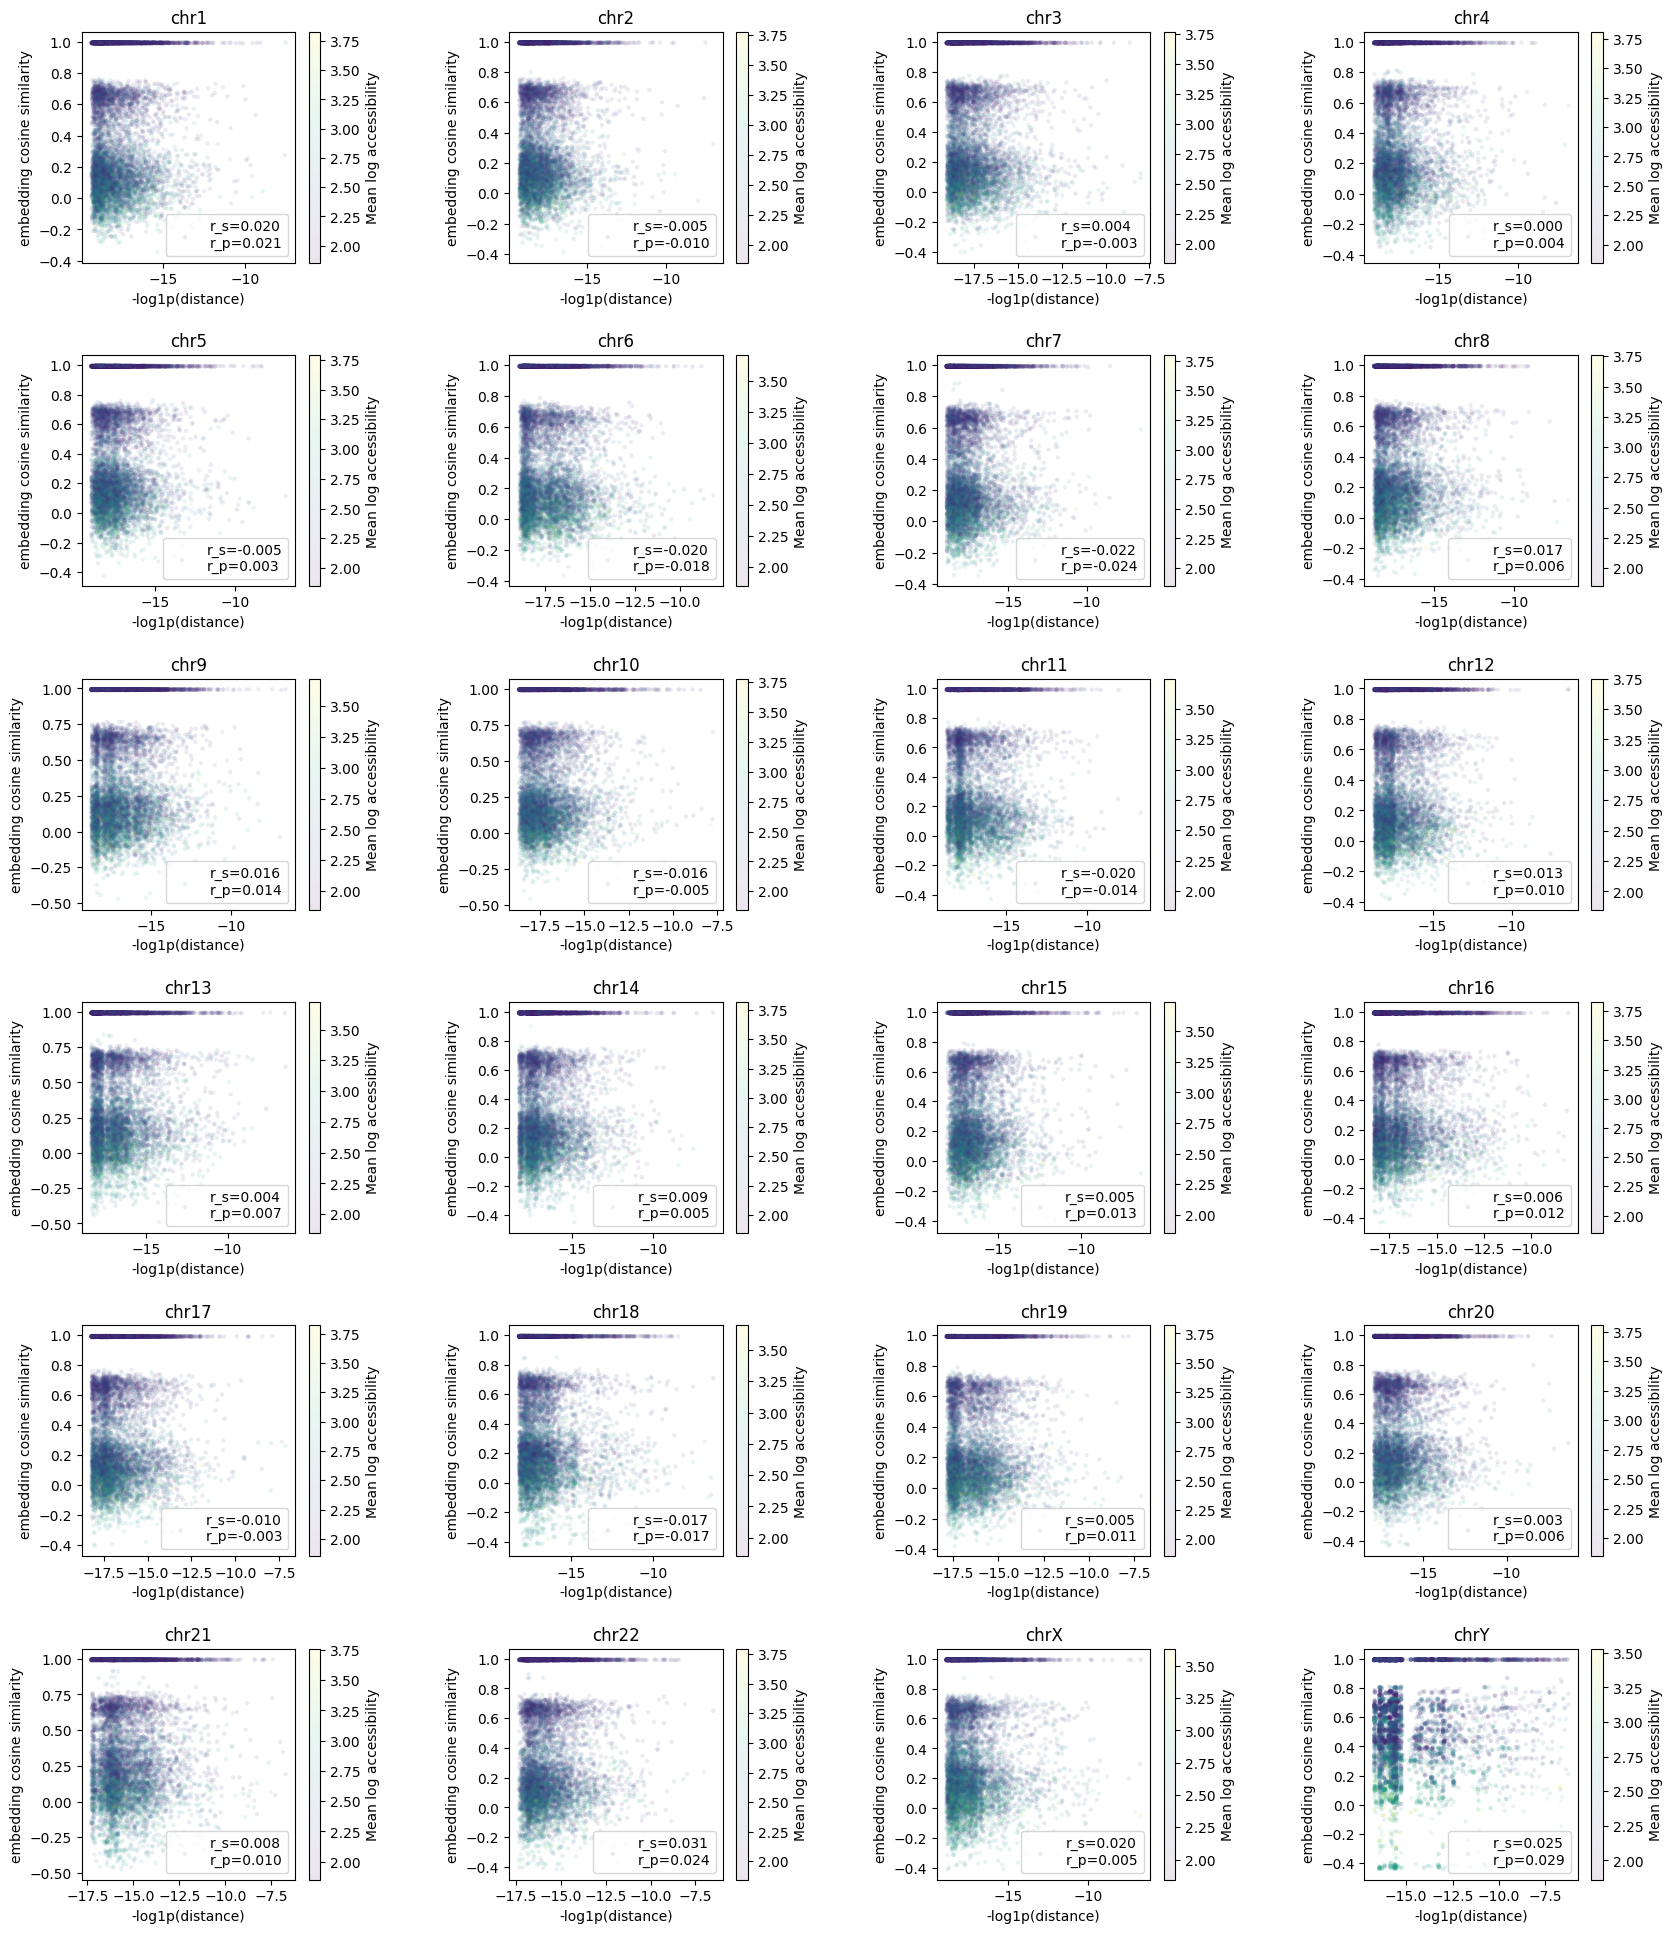

In [85]:
fig, ax = plt.subplots(6, 4, figsize=(20, 24), gridspec_kw={'wspace':0.6, 'hspace':0.4})

n_pairs_chr = 10000
seed = 4

rng = np.random.default_rng(seed)
peak_emb = emb_adata.X
chromosome = emb_adata.obs["Chromosome"].to_numpy()
centers = emb_adata.obs["Center"].to_numpy()

# get peak ids for a specific chromosome
for ax, chr in zip(ax.flatten(), adata.var["Chromosome"].unique()):
    peak_ids = np.where(adata.var["Chromosome"] == chr)[0]

    # sample pairs
    rng = np.random.default_rng(seed=4)
    picks = rng.choice(peak_ids, size=(n_pairs_chr, 2), replace=True)
    i, j = picks[:, 0], picks[:, 1]

    # ensure no self-pairs
    same = i == j
    while np.any(same):
        j[same] = rng.choice(peak_ids, size=int(np.sum(same)), replace=True)
        same = i == j

    # compute distances and similarities
    dist = np.abs(centers[i] - centers[j]).astype(np.float64)
    sim = np.sum(peak_emb[i] * peak_emb[j], axis=1).astype(np.float64)  # cosine

    # Correlate similarity with -log(1+distance) (monotonic decay expectation)
    x = -np.log1p(dist)
    s_r, s_p = spearmanr(sim, x)
    p_r, p_p = pearsonr(sim, x)

    # scatter plot
    colors = (
        adata.var.cisTopic_log_nr_acc.iloc[i].values
        + adata.var.cisTopic_log_nr_acc.iloc[j].values
    ) / 2
    scatter = ax.scatter(
        x,
        sim,
        c=colors,
        alpha=0.1,
        s=10,
        cmap="viridis",
        linewidths=0,
        label=f"r_s={s_r:.3f}\nr_p={p_r:.3f}",
    )
    plt.colorbar(scatter, ax=ax, label='Mean log accessibility')

    ax.set_xlabel('-log1p(distance)')
    ax.set_ylabel('embedding cosine similarity')
    ax.set_title(chr)
    ax.legend()

## Cell embeddings

In [86]:
embedding = model.get_peak_embeddings(normalize=False, which="avg").numpy()

In [87]:
weighted_emb = adata.layers["binary"] @ embedding
norms = np.linalg.norm(weighted_emb, axis=1, keepdims=True) + 1e-10
weighted_emb = weighted_emb / norms
weighted_emb.shape

(10167, 128)

In [88]:
adata.obsm["X_peak2vec"] = weighted_emb

In [89]:
adata.obsm["X_pca"] = sc.pp.pca(adata.obsm["X_peak2vec"], n_comps=50)

In [90]:
sc.pp.neighbors(adata, use_rep="X_peak2vec", n_neighbors=15, n_pcs=50)

In [91]:
sc.tl.umap(adata, random_state=4)

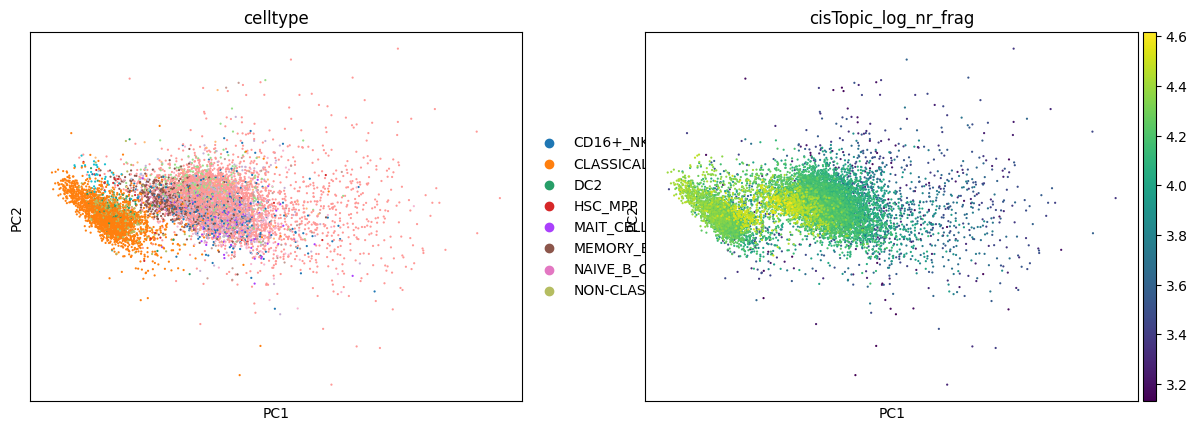

In [92]:
sc.pl.pca(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=2, size=10)

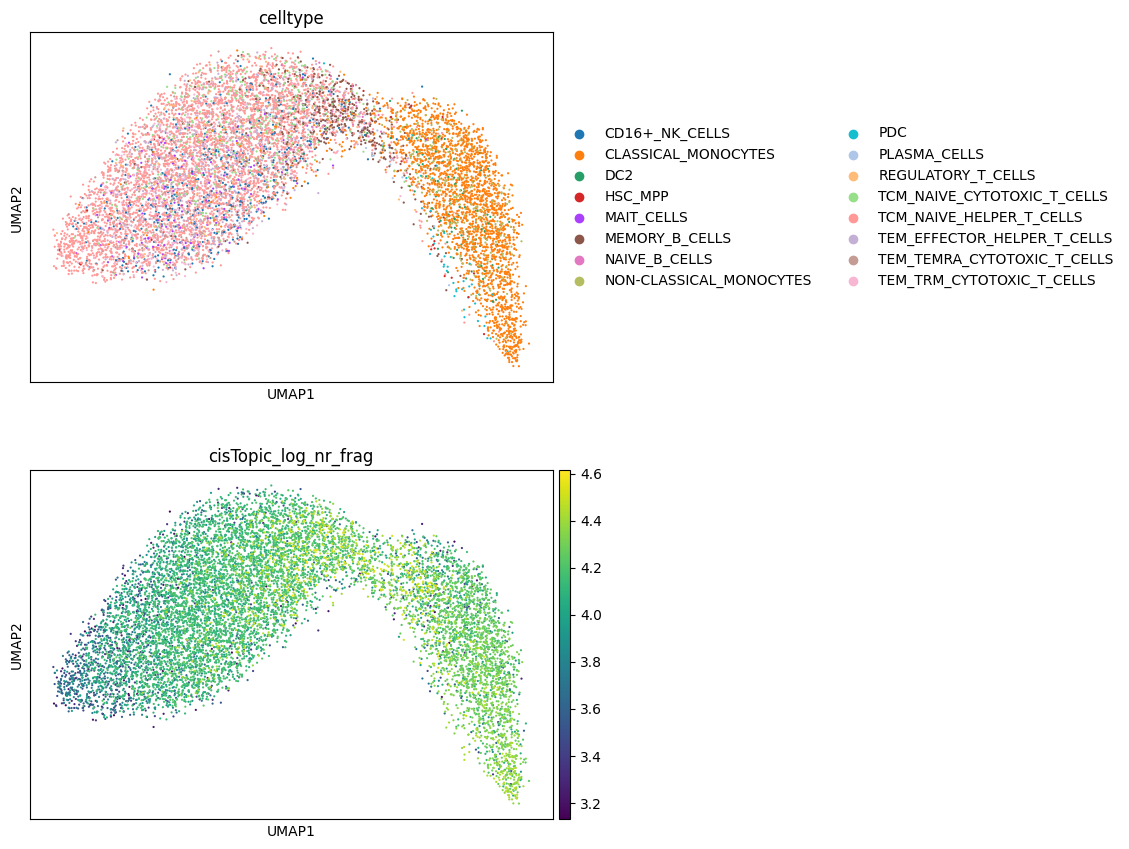

In [93]:
sc.pl.umap(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=1, size=10)